In [1]:
import tensorflow as tf
print(tf.__version__)

import random
import numpy as np
import pandas as pd
import numpy as np
import cv2 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint 
from keras.models import load_model
from sklearn import metrics  
import time


import matplotlib.pyplot as plt

import itertools
!pip install helper

import helper

from keras.models import Model,Sequential
from keras.layers import Input
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

# models benchmark
from keras.applications.densenet import DenseNet201, DenseNet121
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras.applications import VGG16, VGG19

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2.16.1


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for helper: filename=helper-2.5.0-py2.py3-none-any.whl size=19169 sha256=5f410765a7afa64ec255dc64838db58be1686542f3012767931a7cc84334e013
  Stored in directory: /root/.cache/pip/wheels/13/8a/92/4a4267b8371d6e453121c917021173b4a682d691f123b9f647
Successfully built helper


In [2]:
import numpy as np
import tensorflow as tf
import random as python_random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
python_random.seed(seed)

In [3]:
import seaborn as sns

In [4]:
import tensorflow as tf
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
import os
data_dir = "/kaggle/input/input/New Plant Diseases Dataset/New Plant Diseases Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid" 

diseases = os.listdir(train_dir)
diseases

['Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy']

In [6]:
classes = len(diseases)
print("Total de clases por enfermedad: {}".format(classes))

Total de clases por enfermedad: 4


# **Normalización y data augment**

In [7]:
train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.4,
                                   zoom_range = 0.3,
                                   rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)
test_datagen_orig = ImageDataGenerator(rescale = 1./255)

In [8]:
training_set_aug = train_datagen_aug.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224), 
                                               batch_size=32,
                                               class_mode='categorical') # for 2 class binary '''

test_set_orig = test_datagen_orig.flow_from_directory(directory=valid_dir,
                                               target_size=(224, 224), 
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False) # for 2 class binary


Found 6256 images belonging to 4 classes.
Found 804 images belonging to 4 classes.


# ****Modelo DenseNet201****

In [63]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

densenet_model = DenseNet201(include_top=False,
                         input_shape=(224,224,3),
                         weights='imagenet',
                         pooling="avg", 
                         classes = 4)

densenet_model.trainable = True
for layer in densenet_model.layers[:-50]:  # Descongelar las últimas 50 capas
    layer.trainable = False
    
image_input = Input(shape=(224, 224, 3))
x = densenet_model(image_input, training=False)

# Añadir más capas densas con BatchNormalization
x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

image_output = Dense(4, activation='softmax')(x)

model = Model(image_input,image_output)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [64]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=["accuracy"])
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-5)
print(model.summary())

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,900 (94.00 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

None


In [17]:
results = model.fit(training_set_aug,epochs=10,callbacks=[reduce_lr],validation_data=test_set_orig)

Epoch 1/10
196/196 [==============================] - 126s 538ms/step - loss: 0.4071 - accuracy: 0.8342 - val_loss: 0.4217 - val_accuracy: 0.8445
Epoch 2/10
196/196 [==============================] - 84s 426ms/step - loss: 0.1998 - accuracy: 0.9242 - val_loss: 0.4035 - val_accuracy: 0.8570
Epoch 3/10
196/196 [==============================] - 83s 423ms/step - loss: 0.1664 - accuracy: 0.9365 - val_loss: 0.2278 - val_accuracy: 0.9030
Epoch 4/10
196/196 [==============================] - 84s 426ms/step - loss: 0.1384 - accuracy: 0.9498 - val_loss: 0.2776 - val_accuracy: 0.8980
Epoch 5/10
196/196 [==============================] - 83s 424ms/step - loss: 0.1233 - accuracy: 0.9511 - val_loss: 0.3811 - val_accuracy: 0.8756
Epoch 6/10
196/196 [==============================] - 83s 424ms/step - loss: 0.1214 - accuracy: 0.9538 - val_loss: 0.5554 - val_accuracy: 0.8246
Epoch 7/10
196/196 [==============================] - 84s 427ms/step - loss: 0.1078 - accuracy: 0.9578 - val_loss: 0.6766 - val_a

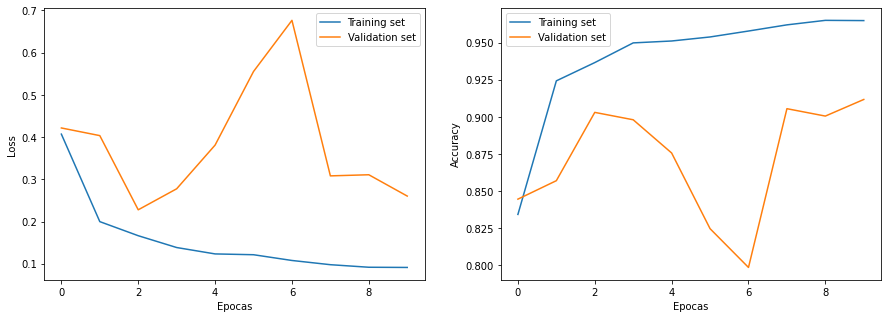

Accuracy: 0.9117
Precision: 0.9184
Recall: 0.9117
F1-Score: 0.9112

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       285
           1       0.91      0.99      0.95       150
           2       0.79      0.93      0.86       178
           3       0.99      0.99      0.99       191

    accuracy                           0.91       804
   macro avg       0.91      0.93      0.92       804
weighted avg       0.92      0.91      0.91       804



In [18]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predice las etiquetas para el conjunto de validación
y_pred = model.predict(test_set_orig)  
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set_orig.classes 


# Graficar el Loss y Accuracy
plt.figure(figsize=(15,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(results.history['loss'], label='Training set')
plt.plot(results.history['val_loss'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], label='Training set')
plt.plot(results.history['val_accuracy'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar un reporte detallado
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))



## ***Guardar Modelo DenseNet201***

In [19]:
model.save('/kaggle/working/model_DenseNet201.h5')
print("Saved model to disk")

Saved model to disk


## ***Pruebas y Predicciones Modelo DenseNet201***

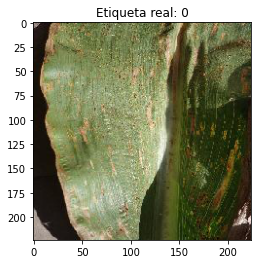

Predicción: 0
Es correcta: True


In [20]:
modelo = load_model("/kaggle/working/model_DenseNet201.h5")

# Etiquetas de las clases
class_labels = test_set_orig.classes


# Obtener una imagen del conjunto de prueba
x, y = next(iter(test_set_orig))

for i in range(1):  
    image = x[i]
    plt.imshow(image)
    plt.title(f"Etiqueta real: {class_labels[np.argmax(y[i])]}")
    plt.show()
    image = image.reshape(1, 224, 224, 3)
    pred_vec = modelo.predict(image)
    pred_class = np.argmax(pred_vec, axis=1)[0]

    print(f"Predicción: {class_labels[pred_class]}")
    print(f"Es correcta: {class_labels[pred_class] == class_labels[np.argmax(y[i])]}")

## ***Matriz Confusión DenseNet201***

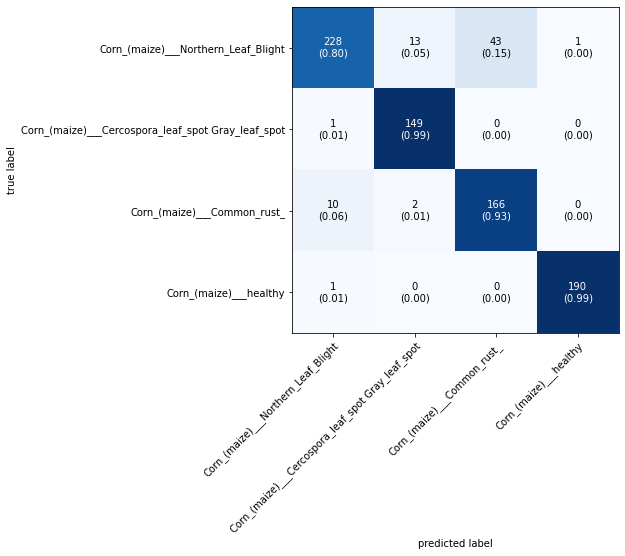

<Figure size 432x288 with 0 Axes>

In [21]:
pred = modelo.predict(test_set_orig)
predictions = np.argmax(pred,axis=1)
confusion201 = confusion_matrix(class_labels,predictions)

fig, ax = plot_confusion_matrix(conf_mat=confusion201,
                                figsize = (6,6),
                                show_normed=True,
                                class_names=diseases)
plt.show()
plt.tight_layout()

# ***Modelo DenseNet121***

In [22]:
densenet_model121 = DenseNet121(include_top=False,
                         input_shape=(224,224,3),
                         weights='imagenet',
                         pooling="max", 
                         classes = 4)

densenet_model121.trainable = True
for layer in densenet_model121.layers[:-50]:  # Descongelar las últimas 50 capas
    layer.trainable = False
    
image_input = Input(shape=(224, 224, 3))
x = densenet_model121(image_input, training=False)

# Añadir más capas densas con BatchNormalization
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)


image_output = Dense(4, activation='softmax')(x)

model121 = Model(image_input,image_output)


29097984/29084464 [==============================] - 1s 0us/step


In [23]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model121.compile(optimizer=opt,loss='categorical_crossentropy', metrics=["accuracy"])
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-5)
print(model121.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0   

In [24]:
results121 = model121.fit(training_set_aug,epochs=10,validation_data=test_set_orig)

Epoch 1/10
196/196 [==============================] - 89s 420ms/step - loss: 0.5903 - accuracy: 0.7586 - val_loss: 0.9404 - val_accuracy: 0.6493
Epoch 2/10
196/196 [==============================] - 79s 405ms/step - loss: 0.2616 - accuracy: 0.8972 - val_loss: 0.5617 - val_accuracy: 0.7600
Epoch 3/10
196/196 [==============================] - 81s 413ms/step - loss: 0.2073 - accuracy: 0.9185 - val_loss: 0.3163 - val_accuracy: 0.8694
Epoch 4/10
196/196 [==============================] - 79s 403ms/step - loss: 0.1682 - accuracy: 0.9343 - val_loss: 0.5648 - val_accuracy: 0.7886
Epoch 5/10
196/196 [==============================] - 79s 400ms/step - loss: 0.1543 - accuracy: 0.9405 - val_loss: 0.5097 - val_accuracy: 0.8122
Epoch 6/10
196/196 [==============================] - 79s 401ms/step - loss: 0.1286 - accuracy: 0.9522 - val_loss: 0.2957 - val_accuracy: 0.9055
Epoch 7/10
196/196 [==============================] - 79s 405ms/step - loss: 0.1284 - accuracy: 0.9522 - val_loss: 0.2619 - val_ac

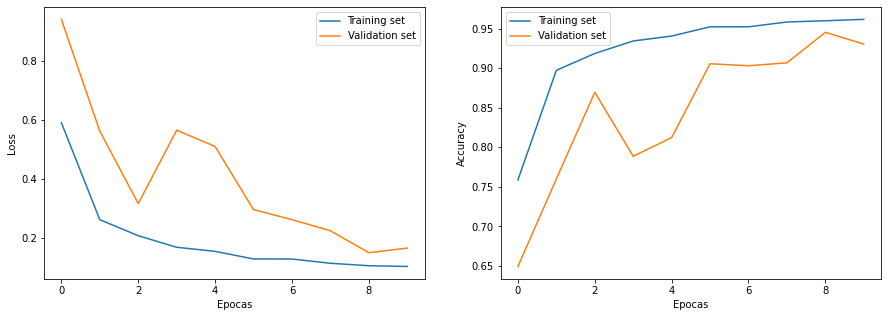

Accuracy: 0.9303
Precision: 0.9305
Recall: 0.9303
F1-Score: 0.9294

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       285
           1       0.95      1.00      0.97       150
           2       0.92      0.81      0.86       178
           3       0.99      0.99      0.99       191

    accuracy                           0.93       804
   macro avg       0.94      0.93      0.93       804
weighted avg       0.93      0.93      0.93       804



In [25]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predice las etiquetas para el conjunto de validación
y_pred = model121.predict(test_set_orig)  
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set_orig.classes 

# # Imprimir el resumen del modelo
# print(model121.summary())

# Graficar el Loss y Accuracy
plt.figure(figsize=(15,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(results121.history['loss'], label='Training set')
plt.plot(results121.history['val_loss'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(results121.history['accuracy'], label='Training set')
plt.plot(results121.history['val_accuracy'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar un reporte detallado
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))



## ***Guardar Modelo DenseNet121***

In [26]:
model121.save('/kaggle/working/model_DenseNet121.h5')
print("Saved model to disk")

Saved model to disk


## ***Pruebas y Predicciones Modelo DenseNet121***

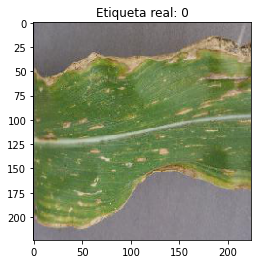

Predicción: 0
Es correcta: True


In [27]:
modelo121 = load_model("/kaggle/working/model_DenseNet121.h5")

# Etiquetas de las clases
class_labels = test_set_orig.classes

# Obtener una imagen del conjunto de prueba
x, y = next(iter(test_set_orig))

for i in range(1):  
    image = x[i]
    plt.imshow(image)
    plt.title(f"Etiqueta real: {class_labels[np.argmax(y[i])]}")
    plt.show()
    image = image.reshape(1, 224, 224, 3)
    pred_vec = modelo121.predict(image)
    pred_class = np.argmax(pred_vec, axis=1)[0]

    print(f"Predicción: {class_labels[pred_class]}")
    print(f"Es correcta: {class_labels[pred_class] == class_labels[np.argmax(y[i])]}")

## ***Matriz Confusión Modelo DenseNet121***

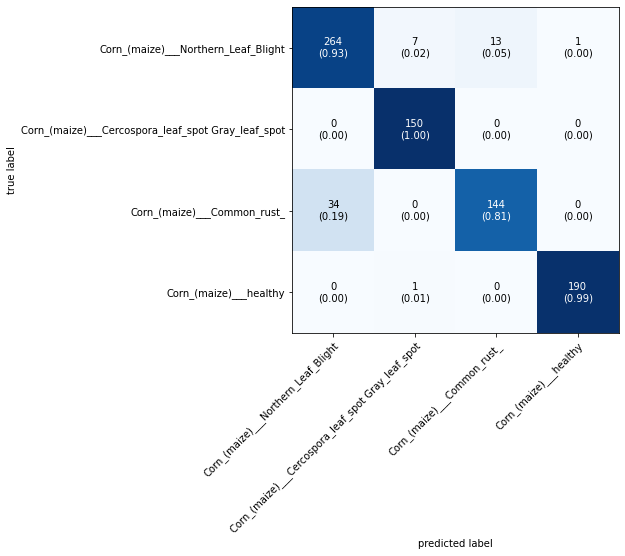

<Figure size 432x288 with 0 Axes>

In [28]:
pred = modelo121.predict(test_set_orig)
predictions = np.argmax(pred,axis=1)
confusion121 = confusion_matrix(class_labels,predictions)

fig, ax = plot_confusion_matrix(conf_mat=confusion121,
                                figsize = (6,6),
                                show_normed=True,
                                class_names=diseases)
plt.show()
plt.tight_layout()

# ***Modelo ResNet50***

In [9]:
model_ResNet50 = ResNet50(include_top=False,
                           input_shape=(224, 224, 3),
                           weights='imagenet',
                           pooling='max')

image_input = Input(shape=(224, 224, 3))
x = model_ResNet50(image_input, training=False)

# Add new Dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

image_output = Dense(4, activation='softmax')(x)  

model_resnet_50 = Model(image_input, image_output)

for layer in model_ResNet50.layers[-30:]: 
    layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_resnet_50.compile(optimizer=opt,loss='categorical_crossentropy', metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)
print(model_resnet_50.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,884,036 (91.11 MB)

 Trainable params: 23,830,916 (90.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [11]:
results_resnet_50 = model_resnet_50.fit(training_set_aug, epochs=10,
                               callbacks=[reduce_lr], validation_data=test_set_orig)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727988126.410526     129 service.cc:145] XLA service 0x7f337400aac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727988126.410587     129 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727988126.410591     129 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727988159.871201     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 208s 708ms/step - accuracy: 0.5784 - loss: 2.7019 - val_accuracy: 0.1480 - val_loss: 1.9735 - learning_rate: 1.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 402ms/step - accuracy: 0.8681 - loss: 0.3662 - val_accuracy: 0.2948 - val_loss: 1.7573 - learning_rate: 1.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 79s 387ms/step - accuracy: 0.8993 - loss: 0.2916 - val_accuracy: 0.4179 - val_loss: 3.9592 - learning_rate: 1.0000e-04
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 79s 389ms/step - accuracy: 0.9207 - loss: 0.2388 - val_accuracy: 0.4701 - val_loss: 3.6734 - learning_rate: 1.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 80s 391ms/step - accuracy: 0.9426 - loss: 0.2071 - val_accuracy: 0.8284 - val_loss: 0.5980 - learning_rate: 1.0000e-04
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 81s 398ms/step - accuracy: 0.9372 - loss: 0.1827 - val_accuracy: 0.8507 - val_loss: 0.3854 - learning_rate: 1.0000e-04
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 406ms/step -

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step


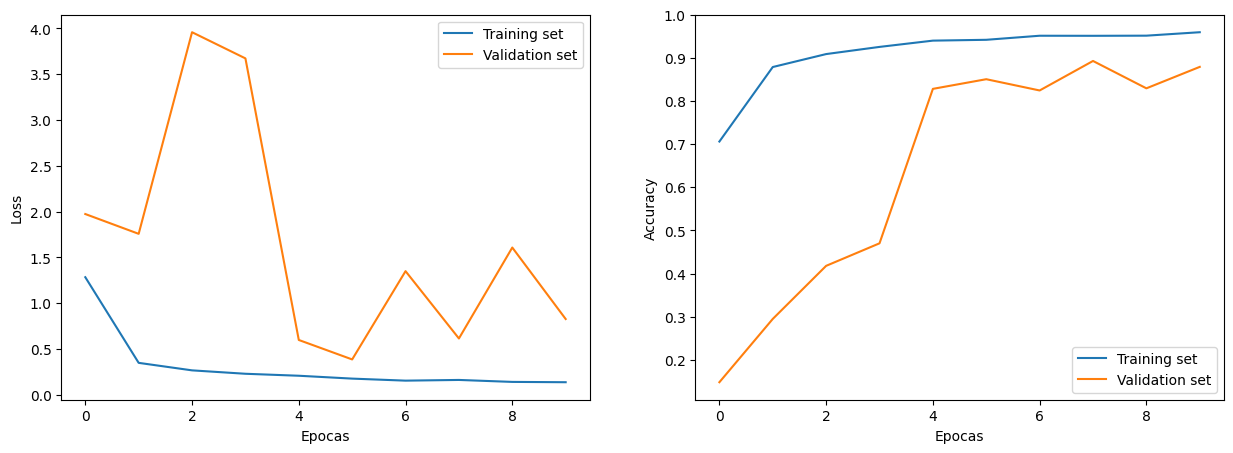

Accuracy: 0.8794
Precision: 0.9002
Recall: 0.8794
F1-Score: 0.8794

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.72      0.81       285
           1       0.69      1.00      0.82       150
           2       0.92      0.90      0.91       178
           3       0.99      1.00      1.00       191

    accuracy                           0.88       804
   macro avg       0.88      0.91      0.88       804
weighted avg       0.90      0.88      0.88       804



In [12]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predice las etiquetas para el conjunto de validación
y_pred = model_resnet_50.predict(test_set_orig)  
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set_orig.classes 

# # Imprimir el resumen del modelo
# print(model121.summary())

# Graficar el Loss y Accuracy
plt.figure(figsize=(15,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(results_resnet_50.history['loss'], label='Training set')
plt.plot(results_resnet_50.history['val_loss'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(results_resnet_50.history['accuracy'], label='Training set')
plt.plot(results_resnet_50.history['val_accuracy'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar un reporte detallado
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))


## ***Guardar Modelo ResNet50***

In [18]:
model_resnet_50.save('/kaggle/working/model_ResNet50.h5')
print("Saved model to disk")

Saved model to disk


## ***Pruebas y Predicciones Modelo ResNet50***

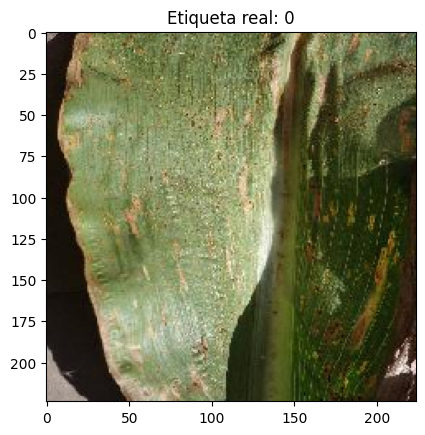

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicción: 0
Es correcta: True


In [19]:
modeloResNet50 = load_model("/kaggle/working/model_ResNet50.h5")

# Etiquetas de las clases
class_labels = test_set_orig.classes


# Obtener una imagen del conjunto de prueba
x, y = next(iter(test_set_orig))

for i in range(1):  
    image = x[i]
    plt.imshow(image)
    plt.title(f"Etiqueta real: {class_labels[np.argmax(y[i])]}")
    plt.show()
    image = image.reshape(1, 224, 224, 3)
    pred_vec = modeloResNet50.predict(image)
    pred_class = np.argmax(pred_vec, axis=1)[0]

    print(f"Predicción: {class_labels[pred_class]}")
    print(f"Es correcta: {class_labels[pred_class] == class_labels[np.argmax(y[i])]}")

## ***Matriz Confusión Modelo ResNet50***

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step


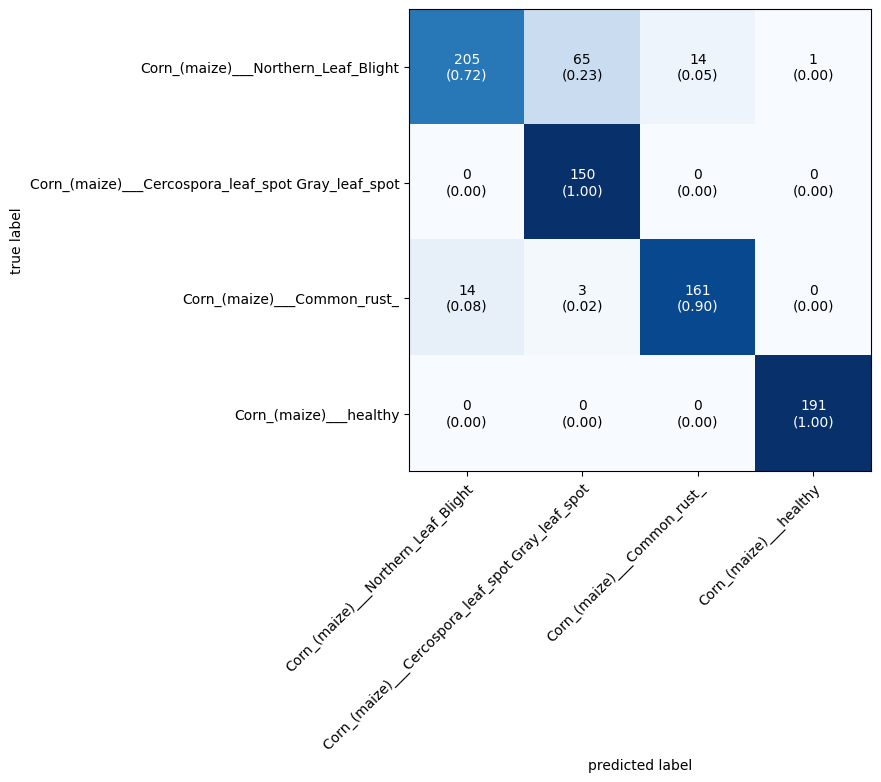

<Figure size 640x480 with 0 Axes>

In [20]:
pred = modeloResNet50.predict(test_set_orig)
predictions = np.argmax(pred,axis=1)
confusionResNet50 = confusion_matrix(class_labels,predictions)

fig, ax = plot_confusion_matrix(conf_mat=confusionResNet50,
                                figsize = (6,6),
                                show_normed=True,
                                class_names=diseases)
plt.show()
plt.tight_layout()

# ***Modelo ResNet101***

In [14]:
model_ResNet101 = ResNet101(include_top=False,
                           input_shape=(224, 224, 3),
                           weights='imagenet',
                           pooling='max')

image_input = Input(shape=(224, 224, 3))
x = model_ResNet101(image_input, training=False)

# Add new Dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

image_output = Dense(4, activation='softmax')(x)  

model_resnet_101 = Model(image_input, image_output)

for layer in model_ResNet101.layers[-30:]: 
    layer.trainable = True

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_resnet_101.compile(optimizer=opt,loss='categorical_crossentropy', metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)
print(model_resnet_101.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,954,500 (163.86 MB)

 Trainable params: 42,849,156 (163.46 MB)

 Non-trainable params: 105,344 (411.50 KB)

None


In [17]:
results_resnet_101 = model_resnet_101.fit(training_set_aug, epochs=10,
                               callbacks=[reduce_lr], validation_data=test_set_orig)

Epoch 1/10


I0000 00:00:1727990059.197406     127 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_51', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_50', 24 bytes spill stores, 24 bytes spill loads



196/196 ━━━━━━━━━━━━━━━━━━━━ 270s 832ms/step - accuracy: 0.5530 - loss: 2.6304 - val_accuracy: 0.2761 - val_loss: 4.1463 - learning_rate: 1.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 106s 523ms/step - accuracy: 0.8752 - loss: 0.3628 - val_accuracy: 0.1493 - val_loss: 26.9296 - learning_rate: 1.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 106s 522ms/step - accuracy: 0.9093 - loss: 0.2816 - val_accuracy: 0.1891 - val_loss: 18.7640 - learning_rate: 1.0000e-04
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 105s 522ms/step - accuracy: 0.9402 - loss: 0.1926 - val_accuracy: 0.4179 - val_loss: 9.3161 - learning_rate: 1.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 106s 523ms/step - accuracy: 0.9373 - loss: 0.2093 - val_accuracy: 0.4789 - val_loss: 6.1119 - learning_rate: 1.0000e-04
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 105s 520ms/step - accuracy: 0.9432 - loss: 0.1985 - val_accuracy: 0.8595 - val_loss: 0.4849 - learning_rate: 1.0000e-04
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 105s 523m

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step


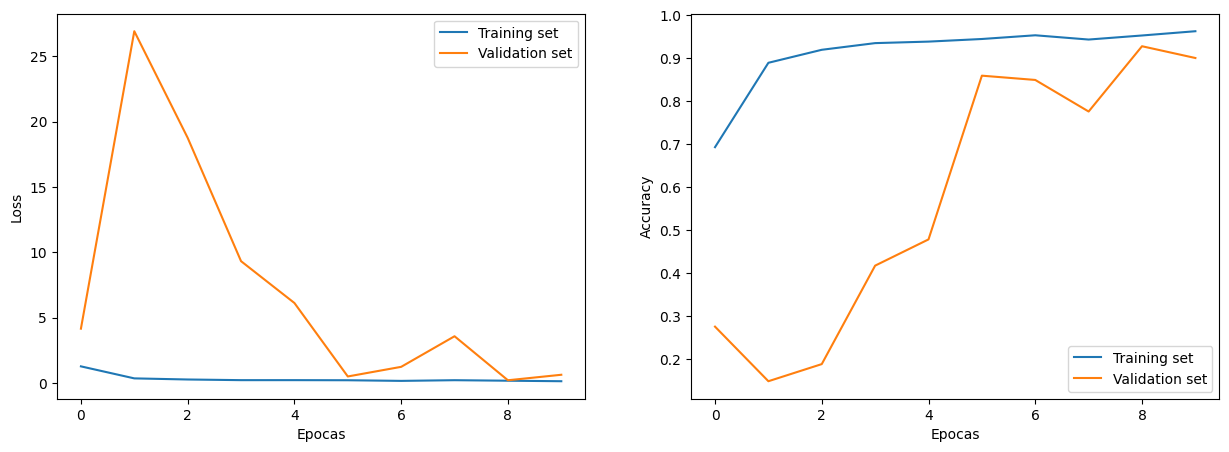

Accuracy: 0.9005
Precision: 0.9119
Recall: 0.9005
F1-Score: 0.9002

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85       285
           1       0.75      0.99      0.85       150
           2       0.92      0.92      0.92       178
           3       1.00      1.00      1.00       191

    accuracy                           0.90       804
   macro avg       0.90      0.92      0.90       804
weighted avg       0.91      0.90      0.90       804



In [21]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predice las etiquetas para el conjunto de validación
y_pred = model_resnet_101.predict(test_set_orig)  
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set_orig.classes 

# # Imprimir el resumen del modelo
# print(model121.summary())

# Graficar el Loss y Accuracy
plt.figure(figsize=(15,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(results_resnet_101.history['loss'], label='Training set')
plt.plot(results_resnet_101.history['val_loss'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(results_resnet_101.history['accuracy'], label='Training set')
plt.plot(results_resnet_101.history['val_accuracy'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar un reporte detallado
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))

## ***Guardar Modelo ResNet101***

In [22]:
model_resnet_101.save('/kaggle/working/model_ResNet101.h5')
print("Saved model to disk")

Saved model to disk


## ***Pruebas y Predicciones Modelo ResNet101***

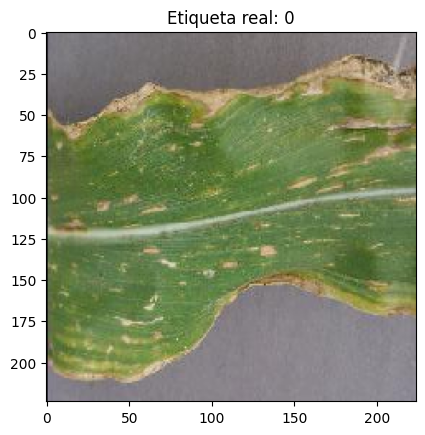

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicción: 0
Es correcta: True


In [23]:
modeloResNet101 = load_model("/kaggle/working/model_ResNet101.h5")

# Etiquetas de las clases
class_labels = test_set_orig.classes


# Obtener una imagen del conjunto de prueba
x, y = next(iter(test_set_orig))

for i in range(1):  
    image = x[i]
    plt.imshow(image)
    plt.title(f"Etiqueta real: {class_labels[np.argmax(y[i])]}")
    plt.show()
    image = image.reshape(1, 224, 224, 3)
    pred_vec = modeloResNet101.predict(image)
    pred_class = np.argmax(pred_vec, axis=1)[0]

    print(f"Predicción: {class_labels[pred_class]}")
    print(f"Es correcta: {class_labels[pred_class] == class_labels[np.argmax(y[i])]}")

## ***Matriz Confusión Modelo ResNet101***

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step


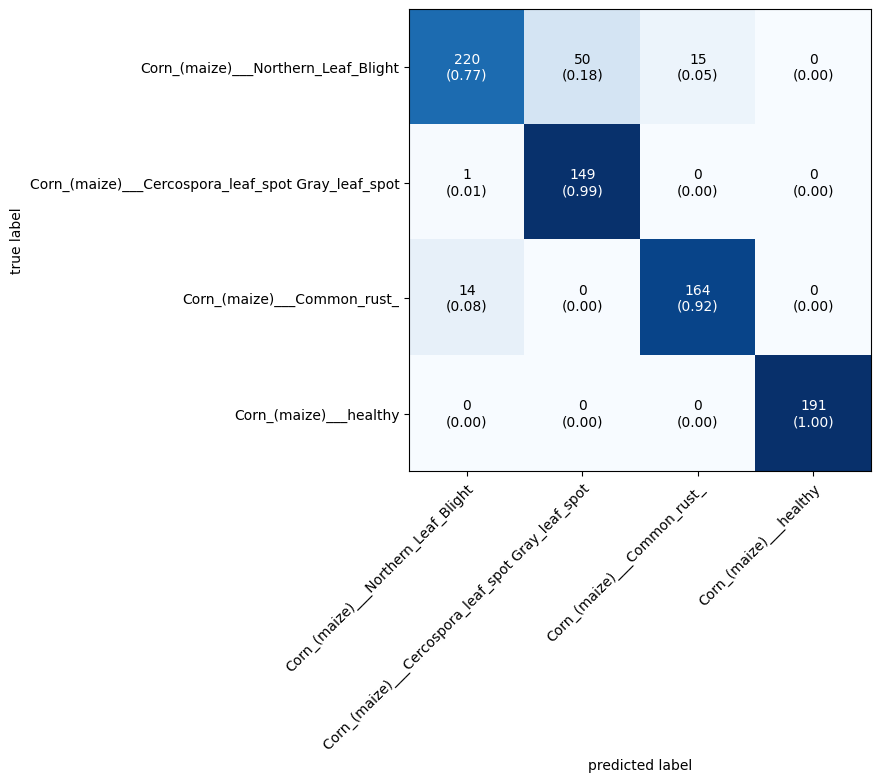

<Figure size 640x480 with 0 Axes>

In [24]:
pred = modeloResNet101.predict(test_set_orig)
predictions = np.argmax(pred,axis=1)
confusionResNet101 = confusion_matrix(class_labels,predictions)

fig, ax = plot_confusion_matrix(conf_mat=confusionResNet101,
                                figsize = (6,6),
                                show_normed=True,
                                class_names=diseases)
plt.show()
plt.tight_layout()

# ***Modelo VGG16***

In [30]:
model_VGG16 = VGG16(include_top=False,
                           input_shape=(224, 224, 3),
                           weights='imagenet',
                           pooling='max')

image_input = Input(shape=(224, 224, 3))
x = model_VGG16(image_input, training=False)

# Add new Dense layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)

image_output = Dense(4, activation='softmax')(x)  

model_vgg_16 = Model(image_input, image_output)

for layer in model_VGG16.layers[-50:]: 
    layer.trainable = True

In [31]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_vgg_16.compile(optimizer=opt,loss='categorical_crossentropy', metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)
print(model_vgg_16.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,428 (56.76 MB)

 Trainable params: 14,879,428 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
results_vgg_16 = model_vgg_16.fit(training_set_aug, epochs=10,
                               callbacks=[reduce_lr], validation_data=test_set_orig)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 102s 460ms/step - accuracy: 0.5018 - loss: 1.1424 - val_accuracy: 0.6381 - val_loss: 1.1373 - learning_rate: 1.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 87s 427ms/step - accuracy: 0.8246 - loss: 0.4022 - val_accuracy: 0.8831 - val_loss: 0.3144 - learning_rate: 1.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 87s 428ms/step - accuracy: 0.8957 - loss: 0.2828 - val_accuracy: 0.7425 - val_loss: 0.8629 - learning_rate: 1.0000e-04
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 86s 422ms/step - accuracy: 0.9241 - loss: 0.2251 - val_accuracy: 0.9067 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 86s 422ms/step - accuracy: 0.9247 - loss: 0.2013 - val_accuracy: 0.8097 - val_loss: 0.6223 - learning_rate: 1.0000e-04
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 86s 424ms/step - accuracy: 0.9416 - loss: 0.1621 - val_accuracy: 0.8769 - val_loss: 0.3348 - learning_rate: 1.0000e-04
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 86s 4

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step


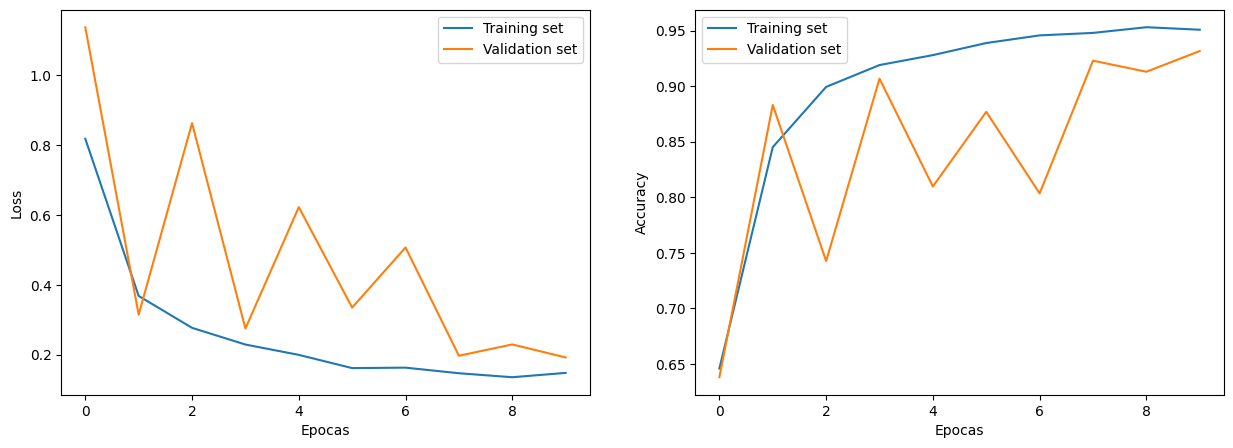

Accuracy: 0.9316
Precision: 0.9368
Recall: 0.9316
F1-Score: 0.9311

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90       285
           1       0.90      0.99      0.94       150
           2       0.85      0.96      0.90       178
           3       1.00      1.00      1.00       191

    accuracy                           0.93       804
   macro avg       0.93      0.95      0.94       804
weighted avg       0.94      0.93      0.93       804



In [33]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predice las etiquetas para el conjunto de validación
y_pred = model_vgg_16.predict(test_set_orig)  
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set_orig.classes 

# # Imprimir el resumen del modelo
# print(model121.summary())

# Graficar el Loss y Accuracy
plt.figure(figsize=(15,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(results_vgg_16.history['loss'], label='Training set')
plt.plot(results_vgg_16.history['val_loss'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(results_vgg_16.history['accuracy'], label='Training set')
plt.plot(results_vgg_16.history['val_accuracy'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar un reporte detallado
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))

## ***Guardar Modelo VGG16***

In [34]:
model_vgg_16.save('/kaggle/working/model_VGG16.h5')
print("Saved model to disk")

Saved model to disk


## ***Pruebas y Predicciones Modelo VGG16***

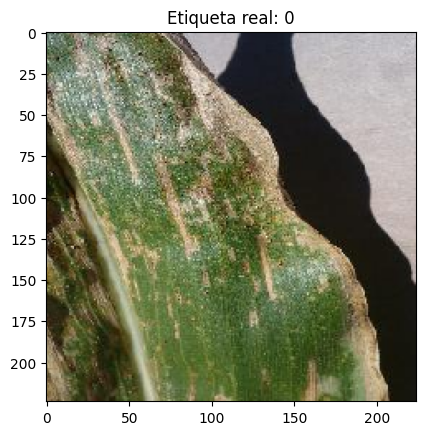

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicción: 0
Es correcta: True


In [35]:
modeloVGG16 = load_model("/kaggle/working/model_VGG16.h5")

# Etiquetas de las clases
class_labels = test_set_orig.classes


# Obtener una imagen del conjunto de prueba
x, y = next(iter(test_set_orig))

for i in range(1):  
    image = x[i]
    plt.imshow(image)
    plt.title(f"Etiqueta real: {class_labels[np.argmax(y[i])]}")
    plt.show()
    image = image.reshape(1, 224, 224, 3)
    pred_vec = modeloVGG16.predict(image)
    pred_class = np.argmax(pred_vec, axis=1)[0]

    print(f"Predicción: {class_labels[pred_class]}")
    print(f"Es correcta: {class_labels[pred_class] == class_labels[np.argmax(y[i])]}")

## ***Matriz Confusión Modelo VGG16***

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step


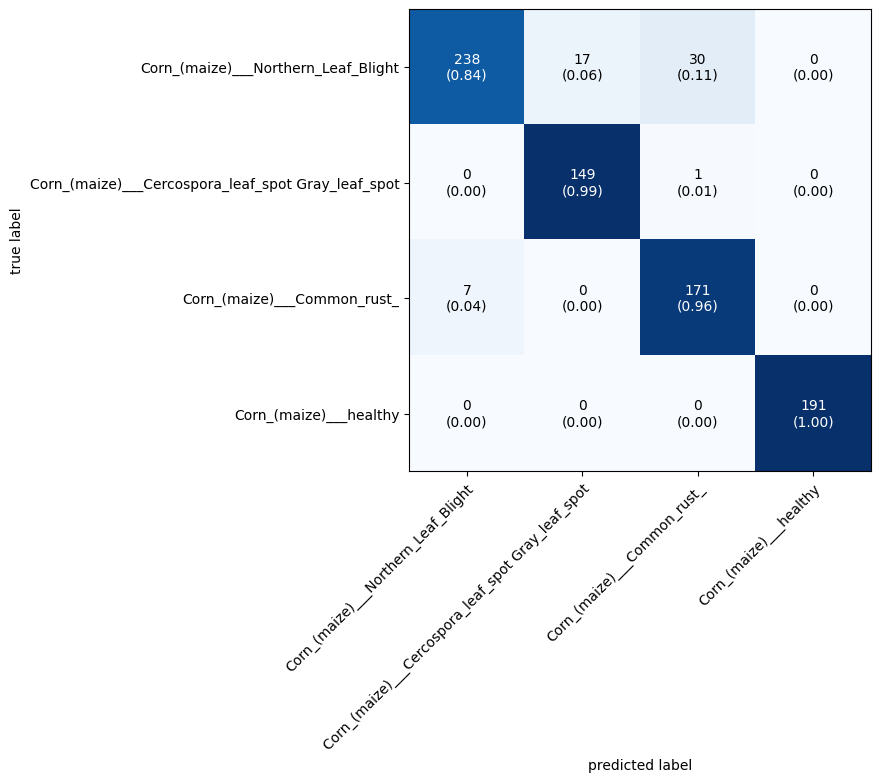

<Figure size 640x480 with 0 Axes>

In [53]:
pred = modeloVGG16.predict(test_set_orig)
predictions = np.argmax(pred,axis=1)
confusionVGG16 = confusion_matrix(class_labels,predictions)

fig, ax = plot_confusion_matrix(conf_mat=confusionVGG16,
                                figsize = (6,6),
                                show_normed=True,
                                class_names=diseases)
plt.show()
plt.tight_layout()

# ***Modelo VGG19***

In [49]:
model_VGG19 = VGG19(include_top=False,
                           input_shape=(224, 224, 3),
                           weights='imagenet',
                           pooling='max')

image_input = Input(shape=(224, 224, 3))
x = model_VGG19(image_input, training=False)

# Add new Dense layers
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.45)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)

image_output = Dense(4, activation='softmax')(x)  

model_vgg_19 = Model(image_input, image_output)

for layer in model_VGG19.layers[-50:]: 
    layer.trainable = True

In [50]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_vgg_19.compile(optimizer=opt,loss='categorical_crossentropy', metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
print(model_vgg_19.summary())

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,564 (76.64 MB)

 Trainable params: 20,090,564 (76.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [51]:
results_vgg_19 = model_vgg_19.fit(training_set_aug, epochs=10,
                               callbacks=[reduce_lr], validation_data=test_set_orig)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 112s 522ms/step - accuracy: 0.6468 - loss: 0.7965 - val_accuracy: 0.5808 - val_loss: 1.4014 - learning_rate: 1.0000e-04
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 101s 500ms/step - accuracy: 0.8740 - loss: 0.3089 - val_accuracy: 0.8545 - val_loss: 0.5163 - learning_rate: 1.0000e-04
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 101s 499ms/step - accuracy: 0.9164 - loss: 0.2197 - val_accuracy: 0.8980 - val_loss: 0.2579 - learning_rate: 1.0000e-04
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 100s 497ms/step - accuracy: 0.9255 - loss: 0.1986 - val_accuracy: 0.7052 - val_loss: 1.0696 - learning_rate: 1.0000e-04
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 100s 498ms/step - accuracy: 0.9442 - loss: 0.1610 - val_accuracy: 0.8968 - val_loss: 0.3250 - learning_rate: 1.0000e-04
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 100s 496ms/step - accuracy: 0.9512 - loss: 0.1427 - val_accuracy: 0.9167 - val_loss: 0.2359 - learning_rate: 1.0000e-04
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step


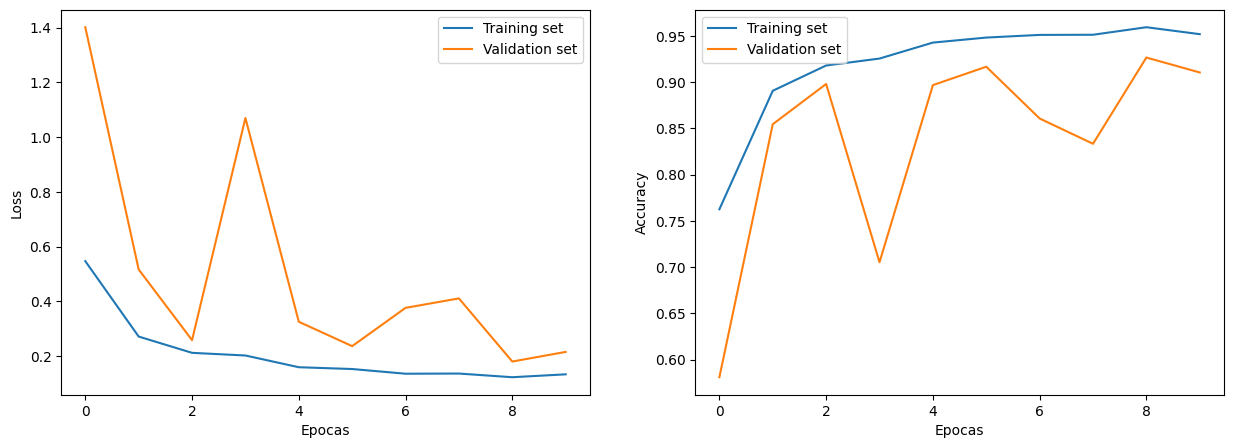

Accuracy: 0.9104
Precision: 0.9155
Recall: 0.9104
F1-Score: 0.9096

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.87       285
           1       0.86      0.99      0.92       150
           2       0.83      0.92      0.87       178
           3       1.00      1.00      1.00       191

    accuracy                           0.91       804
   macro avg       0.91      0.93      0.91       804
weighted avg       0.92      0.91      0.91       804



In [52]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predice las etiquetas para el conjunto de validación
y_pred = model_vgg_19.predict(test_set_orig)  
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set_orig.classes 

# # Imprimir el resumen del modelo
# print(model121.summary())

# Graficar el Loss y Accuracy
plt.figure(figsize=(15,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(results_vgg_19.history['loss'], label='Training set')
plt.plot(results_vgg_19.history['val_loss'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(results_vgg_19.history['accuracy'], label='Training set')
plt.plot(results_vgg_19.history['val_accuracy'], label='Validation set')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar un reporte detallado
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))

## ***Guardar Modelo VGG19***

In [54]:
model_vgg_19.save('/kaggle/working/model_VGG19.h5')
print("Saved model to disk")

Saved model to disk


## ***Pruebas y Predicciones Modelo VGG19***

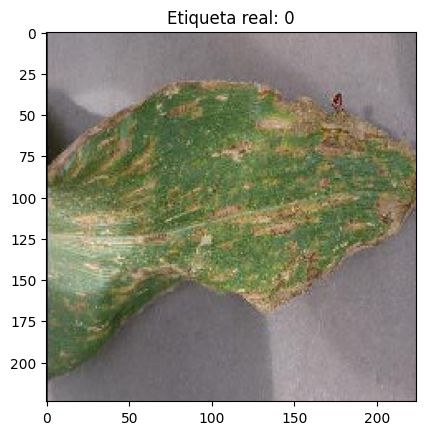

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Predicción: 0
Es correcta: True


In [55]:
modeloVGG19 = load_model("/kaggle/working/model_VGG19.h5")

# Etiquetas de las clases
class_labels = test_set_orig.classes


# Obtener una imagen del conjunto de prueba
x, y = next(iter(test_set_orig))

for i in range(1):  
    image = x[i]
    plt.imshow(image)
    plt.title(f"Etiqueta real: {class_labels[np.argmax(y[i])]}")
    plt.show()
    image = image.reshape(1, 224, 224, 3)
    pred_vec = modeloVGG19.predict(image)
    pred_class = np.argmax(pred_vec, axis=1)[0]

    print(f"Predicción: {class_labels[pred_class]}")
    print(f"Es correcta: {class_labels[pred_class] == class_labels[np.argmax(y[i])]}")

## ***Matriz Confusión Modelo VGG19***

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step


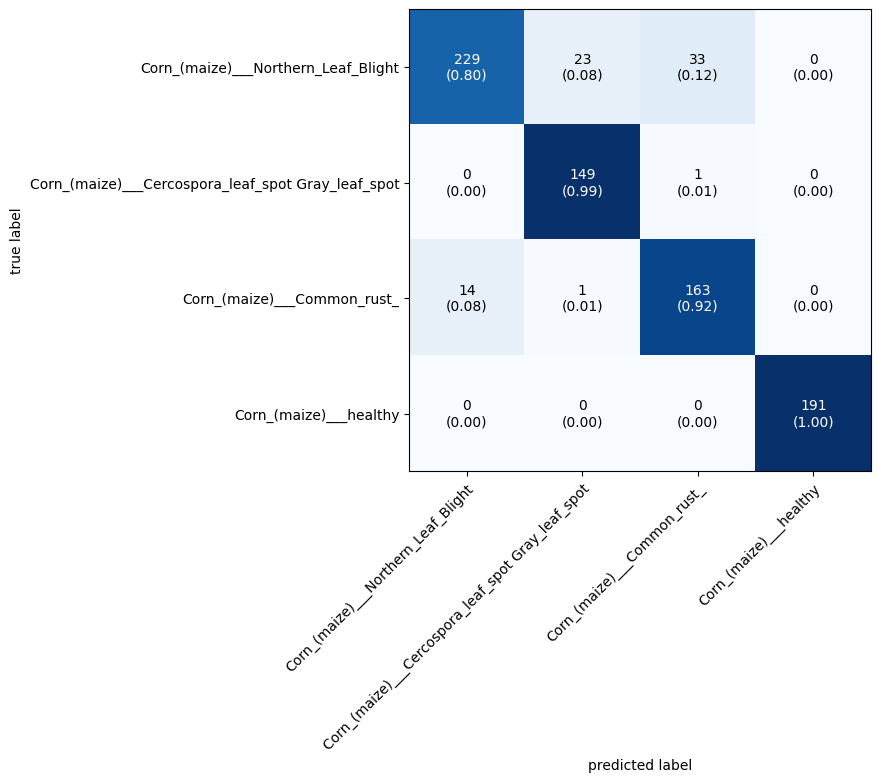

<Figure size 640x480 with 0 Axes>

In [56]:
pred = modeloVGG19.predict(test_set_orig)
predictions = np.argmax(pred,axis=1)
confusionVGG19 = confusion_matrix(class_labels,predictions)

fig, ax = plot_confusion_matrix(conf_mat=confusionVGG19,
                                figsize = (6,6),
                                show_normed=True,
                                class_names=diseases)
plt.show()
plt.tight_layout()

# ***Comparando Modelos DenseNet***

DenseNet201:
Accuracy: 0.9117
Precision: 0.9184
Recall: 0.9117
F1-Score: 0.9112

DenseNet121:
Accuracy: 0.9303
Precision: 0.9305
Recall: 0.9303
F1-Score: 0.9294

DenseNet201 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       285
           1       0.91      0.99      0.95       150
           2       0.79      0.93      0.86       178
           3       0.99      0.99      0.99       191

    accuracy                           0.91       804
   macro avg       0.91      0.93      0.92       804
weighted avg       0.92      0.91      0.91       804


DenseNet121 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       285
           1       0.95      1.00      0.97       150
           2       0.92      0.81      0.86       178
           3       0.99      0.99      0.99       191

    accuracy                           0.93       804
   m

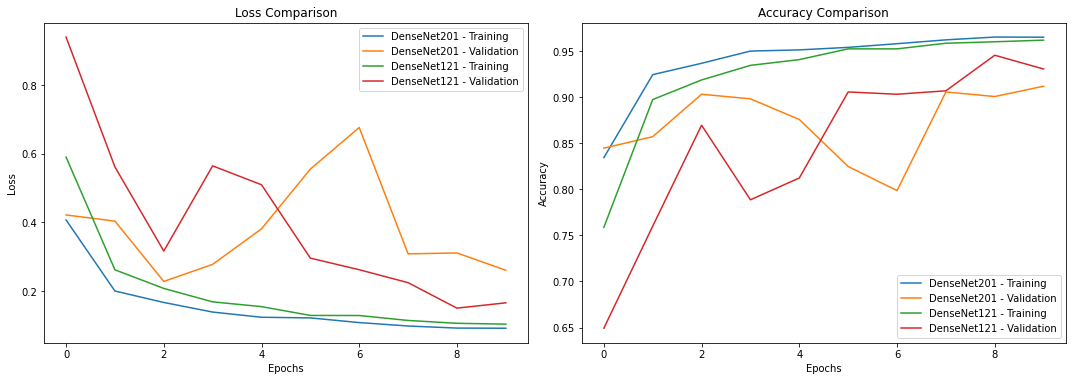

In [29]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Predicciones para DenseNet201
y_pred_densenet201 = model.predict(test_set_orig)
y_pred_classes_densenet201 = np.argmax(y_pred_densenet201, axis=1)

# Predicciones para DenseNet121
y_pred_densenet121 = model121.predict(test_set_orig)
y_pred_classes_densenet121 = np.argmax(y_pred_densenet121, axis=1)

# Etiquetas verdaderas
y_true = test_set_orig.classes

# Calcular métricas para DenseNet201
accuracy_densenet201 = accuracy_score(y_true, y_pred_classes_densenet201)
precision_densenet201 = precision_score(y_true, y_pred_classes_densenet201, average='weighted')
recall_densenet201 = recall_score(y_true, y_pred_classes_densenet201, average='weighted')
f1_densenet201 = f1_score(y_true, y_pred_classes_densenet201, average='weighted')

# Calcular métricas para DenseNet121
accuracy_densenet121 = accuracy_score(y_true, y_pred_classes_densenet121)
precision_densenet121 = precision_score(y_true, y_pred_classes_densenet121, average='weighted')
recall_densenet121 = recall_score(y_true, y_pred_classes_densenet121, average='weighted')
f1_densenet121 = f1_score(y_true, y_pred_classes_densenet121, average='weighted')

# Mostrar las métricas
print("DenseNet201:")
print(f'Accuracy: {accuracy_densenet201:.4f}')
print(f'Precision: {precision_densenet201:.4f}')
print(f'Recall: {recall_densenet201:.4f}')
print(f'F1-Score: {f1_densenet201:.4f}')

print("\nDenseNet121:")
print(f'Accuracy: {accuracy_densenet121:.4f}')
print(f'Precision: {precision_densenet121:.4f}')
print(f'Recall: {recall_densenet121:.4f}')
print(f'F1-Score: {f1_densenet121:.4f}')

# Mostrar reportes detallados
print("\nDenseNet201 Classification Report:\n", classification_report(y_true, y_pred_classes_densenet201))
print("\nDenseNet121 Classification Report:\n", classification_report(y_true, y_pred_classes_densenet121))

# Graficar el Loss y Accuracy para ambos modelos
plt.figure(figsize=(15, 10))

# Pérdida
plt.subplot(2, 2, 1)
plt.plot(results.history['loss'], label='DenseNet201 - Training')
plt.plot(results.history['val_loss'], label='DenseNet201 - Validation')
plt.plot(results121.history['loss'], label='DenseNet121 - Training')
plt.plot(results121.history['val_loss'], label='DenseNet121 - Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(results.history['accuracy'], label='DenseNet201 - Training')
plt.plot(results.history['val_accuracy'], label='DenseNet201 - Validation')
plt.plot(results121.history['accuracy'], label='DenseNet121 - Training')
plt.plot(results121.history['val_accuracy'], label='DenseNet121 - Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.tight_layout()
plt.show()


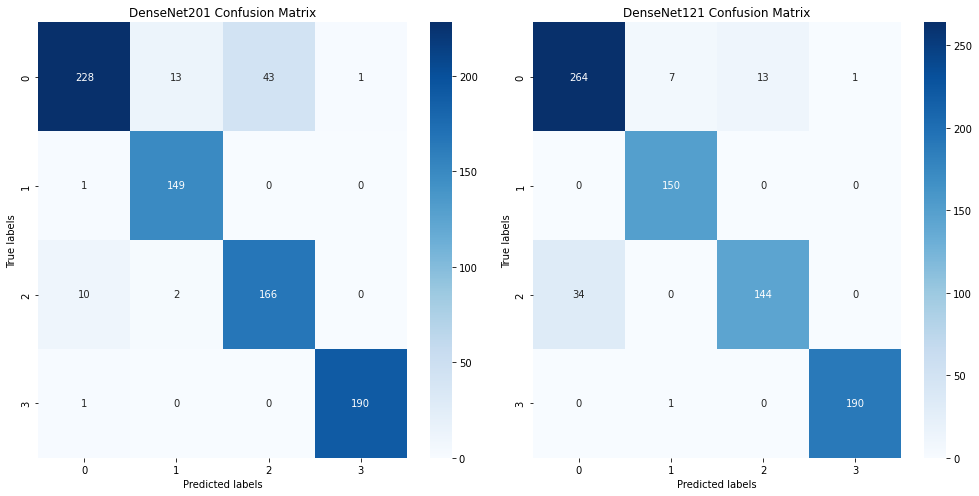

In [30]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot DenseNet201 confusion matrix
sns.heatmap(confusion201, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('DenseNet201 Confusion Matrix')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')

# Plot DenseNet121 confusion matrix
sns.heatmap(confusion121, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('DenseNet121 Confusion Matrix')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')

plt.tight_layout()
plt.show()

# ***Comparando Modelos ResNet***

In [58]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Predicciones para ResNet50
y_pred_resnet50 = model_resnet_50.predict(test_set_orig)
y_pred_classes_resnet50 = np.argmax(y_pred_resnet50, axis=1)

# Predicciones para ResNet101
y_pred_resnet101 = model_resnet_101.predict(test_set_orig)
y_pred_classes_resnet101 = np.argmax(y_pred_resnet101, axis=1)

# Etiquetas verdaderas
y_true = test_set_orig.classes

# Calcular métricas para DenseNet201
accuracy_resnet50 = accuracy_score(y_true, y_pred_classes_resnet50)
precision_resnet50 = precision_score(y_true, y_pred_classes_resnet50, average='weighted')
recall_resnet50 = recall_score(y_true, y_pred_classes_resnet50, average='weighted')
f1_resnet50 = f1_score(y_true, y_pred_classes_resnet50, average='weighted')

# Calcular métricas para DenseNet121
accuracy_resnet101 = accuracy_score(y_true, y_pred_classes_resnet101)
precision_resnet101 = precision_score(y_true, y_pred_classes_resnet101, average='weighted')
recall_resnet101 = recall_score(y_true, y_pred_classes_resnet101, average='weighted')
f1_resnet101 = f1_score(y_true, y_pred_classes_resnet101, average='weighted')

# Mostrar las métricas
print("ResNet50:")
print(f'Accuracy: {accuracy_resnet50:.4f}')
print(f'Precision: {precision_resnet50:.4f}')
print(f'Recall: {recall_resnet50:.4f}')
print(f'F1-Score: {f1_resnet50:.4f}')

print("\nResNet101:")
print(f'Accuracy: {accuracy_resnet101:.4f}')
print(f'Precision: {precision_resnet101:.4f}')
print(f'Recall: {recall_resnet101:.4f}')
print(f'F1-Score: {f1_resnet101:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step
ResNet50:
Accuracy: 0.8794
Precision: 0.9002
Recall: 0.8794
F1-Score: 0.8794

ResNet101:
Accuracy: 0.9005
Precision: 0.9119
Recall: 0.9005
F1-Score: 0.9002


# ***Comparando Modelos VGG***

In [59]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Predicciones para ResNet50
y_pred_vgg16 = model_vgg_16.predict(test_set_orig)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)

# Predicciones para ResNet101
y_pred_vgg19 = model_vgg_19.predict(test_set_orig)
y_pred_classes_vgg19 = np.argmax(y_pred_vgg19, axis=1)

# Etiquetas verdaderas
y_true = test_set_orig.classes

# Calcular métricas para DenseNet201
accuracy_vgg16 = accuracy_score(y_true, y_pred_classes_vgg16)
precision_vgg16 = precision_score(y_true, y_pred_classes_vgg16, average='weighted')
recall_vgg16 = recall_score(y_true, y_pred_classes_vgg16, average='weighted')
f1_vgg16 = f1_score(y_true, y_pred_classes_vgg16, average='weighted')

# Calcular métricas para DenseNet121
accuracy_vgg19 = accuracy_score(y_true, y_pred_classes_vgg19)
precision_vgg19 = precision_score(y_true, y_pred_classes_vgg19, average='weighted')
recall_vgg19 = recall_score(y_true, y_pred_classes_vgg19, average='weighted')
f1_vgg19 = f1_score(y_true, y_pred_classes_vgg19, average='weighted')

# Mostrar las métricas
print("VGG16:")
print(f'Accuracy: {accuracy_vgg16:.4f}')
print(f'Precision: {precision_vgg16:.4f}')
print(f'Recall: {recall_vgg16:.4f}')
print(f'F1-Score: {f1_vgg16:.4f}')

print("\nVGG19:")
print(f'Accuracy: {accuracy_vgg19:.4f}')
print(f'Precision: {precision_vgg19:.4f}')
print(f'Recall: {recall_vgg19:.4f}')
print(f'F1-Score: {f1_vgg19:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
VGG16:
Accuracy: 0.9316
Precision: 0.9368
Recall: 0.9316
F1-Score: 0.9311

VGG19:
Accuracy: 0.9104
Precision: 0.9155
Recall: 0.9104
F1-Score: 0.9096
